<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Classification Model Analysis for Marvel vs DC reddit

## Part 3 of 3: Hyperparameter tuning and feature engineering after model evaluation and sentiment analysis.
---
Part 1: Scrapping of the data from reddit into csv files

Part 2: Data Cleaning and Exploring Data Analysis (EDA) of scrapped data

Part 3: Hyperparameter tuning and feature engineering after model evaluation and sentiment analysis.

---
From this notebook we will address the following question to determine the best model.
The best model is determined based on the following factors (in- order of priority):
1. Interpretebility of the model (model which is able to indicate more insights)
2. Accuracy (highest score)
3. F-score (highest score)
4. Overfiting / Underfiting of the model (difference between test and train score 5%)
5. Computational time (reasonable computational time)

The models evaluated in this codebook is logistic regression, multinomial naive bayes, k-nearest neighbours and random forest.

Subsequently the following above points are used to address the above shall be used to determine:

1. Tokenization method
Both stemming and lemmatizing has the same corpus length. Hence, the score is determined by the f-score output for a logistic regression model and the higher score is selected in determining the next step of modelling

2. Vectorization method
Both Countvectorizer method and Tfdif Vectorizor method are evaluated to obtain the best model. The score is determined on the model and vector combination for all 4 models tested.

3. Hyperparameter tuning 
A gridsearch is conducted on the set parameters for tdif vectorization and model parameters. The ouput of the model hyper parameter tuning is summarised in a data frame (ht). The best model will be selected according to the factors listed above.

4. Model coefficient variable
A plot of the ROC is plotted for the baseline model, selected model, and the competitive model. Subsequently, the top features of the model is plotted to evaluate on the model coeffecient.

5. Sentiment Analysis on data
Selection of sentiment analysis is conducted on two different sentiment model on Huggingface and the best model was selected for the final dataset. The best model will be selected to run the data for sentiment analysis and output is futher analysed using EDA.

# Define Libraries

In [4]:
import requests
import time
import json
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import regex as re
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_roc_curve, roc_auc_score, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
#from datasets import list_datasets, load_dataset

import seaborn as sns
#from pmaw import PushshiftAPI

import warnings
warnings.filterwarnings("ignore")

# Importing dataset

In [3]:
df = pd.read_csv('./datasets/combined_clean.csv')
print(df.shape)
df.drop(labels = 'Unnamed: 0', axis=1, inplace =True)
print(df.info())
df.head()

(20190, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20190 entries, 0 to 20189
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   is_marvelstudios  20190 non-null  int64 
 1   post              20190 non-null  object
 2   post_clean_lemma  20096 non-null  object
 3   post_clean_stem   20096 non-null  object
dtypes: int64(1), object(3)
memory usage: 631.1+ KB
None


,is_marvelstudios,post,post_clean_lemma,post_clean_stem
0,1,Unpopular Opinion: Who cares that the MCU is l...,unpopular opinion care mcu labeled really not ...,unpopular opinion care mcu label realli not bi...
1,1,What's your favorite MCU Content Youtube Chann...,favorite mcu content youtube channel breakdown...,favorit mcu content youtub channel breakdown e...
2,1,I'd rather rewatch Thor 1 than Thor Ragnarok S...,rather rewatch thor thor ragnarok month ago wa...,rather rewatch thor thor ragnarok month ago wa...
3,1,"Venom is a Mimic Like, they both have the same...",venom mimic design alien kind disguise turn pe...,venom mimic design alien kind disguis turn peo...
4,1,Who do you guys think would win gwenpool or mi...,guy win gwenpool mile morale battling mcu endg...,guy win gwenpool mile moral battl mcu endgam f...


From this notebook the combined dataframe saved in the previous notebook including post from *r/marvelstudios* and *r/DC_Cinematic* subreddits are included in the 

## Dropping of columns with blanks

In [4]:
# (df['post_clean_lemma']==np.nan).

df.loc[df['post_clean_lemma'].isnull()].index

Int64Index([   66,   122,  2926,  3229,  3271,  3278,  3563,  4323,  4752,
             5054,  5142,  5371,  6273,  6302,  7022,  7157,  7186,  7207,
             7243,  7268,  7472,  7574,  7776,  7863,  8087,  8236,  8362,
             8426,  8455,  8507,  8564,  8578,  8631,  8639,  8933,  9058,
             9253,  9473,  9503,  9729,  9957, 10020, 10727, 10832, 10869,
            10923, 10925, 10942, 11053, 11091, 11138, 11159, 11161, 11175,
            11579, 11936, 12161, 12259, 12532, 12677, 12726, 12728, 12729,
            12771, 12922, 13262, 13461, 13462, 13698, 14076, 14385, 14440,
            14636, 14927, 15050, 15051, 15340, 15436, 15458, 15473, 16130,
            16633, 16820, 16931, 16958, 16959, 17080, 17247, 17369, 17498,
            17743, 18132, 18313, 18430],
           dtype='int64')

In [5]:
df.drop(index = df.loc[df['post_clean_lemma'].isnull()].index, inplace = True)
df.shape

(20096, 4)

The non-latin characters are regarded to be outliers as it would not aid in creating an accurate model. Since both DC and marvel subreddit has a 5% and 4% of such outliers (indicated in codebook part 2), it is not significant and removed prior to modelling.

# Building Baseline Model

In [6]:
# Checking on the target variable
y = df['is_marvelstudios']
score = y.value_counts(normalize=True)
score

1    0.500149
0    0.499851
Name: is_marvelstudios, dtype: float64

The baseline is taken to have a 50:50 split using the normalized split. An approximately equal amount of data from both subreddits was combined in the new dataframe. 

# Creation of the test-train data

In [7]:
# Creating hold-up data
X = df['post']
X1 = df['post_clean_lemma']
X2 = df['post_clean_stem']
y = df['is_marvelstudios']
X.shape,X1.shape, X2.shape, y.shape

((20096,), (20096,), (20096,), (20096,))

In [8]:
# Creation of train_test (post)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Creation of train-test data (post_clean_lemma)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2, stratify=y, random_state=42)
print(X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape)

# Creation of train-test data (post_clean_stem)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, stratify=y, random_state=42)
print(X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape)

(16076,) (4020,) (16076,) (4020,)
(16076,) (4020,) (16076,) (4020,)
(16076,) (4020,) (16076,) (4020,)


In [9]:
# Instantiate vectorizers
vectorizers = {'cvec': CountVectorizer(stop_words = 'english'),
               'tvec': TfidfVectorizer(stop_words = 'english')}

In [10]:
# Instiantiate models
models = {'lr': LogisticRegression(max_iter = 1_000, random_state = 42),
          'rf': RandomForestClassifier(random_state = 42),
          'knn': KNeighborsClassifier(),
          'nb': MultinomialNB(),
          'svc': SVC(random_state = 42)
         }

## Model Selection and Selection of tokenizer and vectorization method

In [132]:
# Function to run model -- input vectorizer and model
def run_model(vec, mod, X_train, y_train, X_test,vec_params={}, mod_params={}, grid_search=False):
    
    results = {}
    start_time = time.time()
    pipe = Pipeline([
            (vec, vectorizers[vec]),
            (mod, models[mod])
            ])
    
    if grid_search:
        gs = GridSearchCV(pipe, param_grid = {**vec_params, **mod_params}, cv=5, verbose=1, n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train, y_train)
    
    # Results from model to be input into a dataframe, mod_results
    results['model'] = mod
    results['vectorizer'] = vec
    results['train'] = pipe.score(X_train, y_train)
    results['test'] = pipe.score(X_test, y_test)
    results['% diff'] = (pipe.score(X_train, y_train) - pipe.score(X_test, y_test)) # checking for overfit (less than 5% difference)
    results['computational time (s)'] = (time.time() - start_time)
    predictions = pipe.predict(X_test)
    results['roc'] = roc_auc_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)
    results['accuracy'] = accuracy_score(y_test, predictions)
    
    if grid_search:
        ht.append(results) #Results from model with optimised parameters to be input into a dataframe, ht
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        mod_results.append(results)
    
    print('### MODEL METRICS ###')
    display(results)
    
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot();
    
    return pipe

In [10]:
mod_results = []

## Selection of Tokenization method

### MODEL METRICS ###


{'model': 'lr',
 'vectorizer': 'cvec',
 'train': 0.976922119930331,
 'test': 0.91318407960199,
 '% diff': 0.06373804032834096,
 'computational time (s)': 4.328885793685913,
 'roc': 0.9131797265364041,
 'f_score': 0.9139758442198669,
 'accuracy': 0.91318407960199}

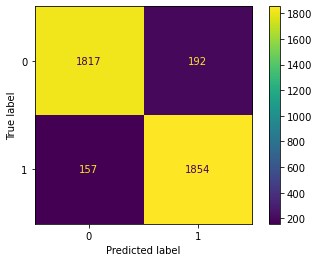

In [112]:
# Logistic Regression with CountVectorizer on stemming 
lr_stem = run_model('cvec', 'lr', X2_train, y2_train, X2_test)

In [113]:
# Reset of the dataframe for the results
mod_results = []

### MODEL METRICS ###


{'model': 'lr',
 'vectorizer': 'cvec',
 'train': 0.980529982582732,
 'test': 0.9146766169154229,
 '% diff': 0.06585336566730915,
 'computational time (s)': 4.381173133850098,
 'roc': 0.9146707791071456,
 'f_score': 0.9157041042025068,
 'accuracy': 0.9146766169154229}

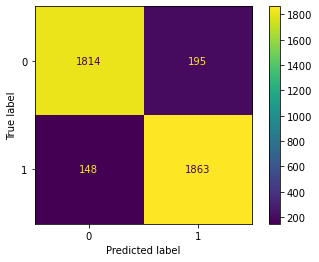

In [114]:
# Logistic Regression with CountVectorizer on lemmatizing
lr_lemm = run_model('cvec', 'lr', X1_train, y1_train, X1_test)

From the above the parameters, the score for the lemmatizing **(f-score=0.915)** is higher than the score for stemming **(f-score=0.913)**. Hence, the lemmatization is the best tokenizing method. The mod_results is resetted to remove the stemming tokenization method from model output.

# Selection of Vectorization Method

### MODEL METRICS ###


{'model': 'lr',
 'vectorizer': 'tvec',
 'train': 0.9669693953719831,
 'test': 0.9213930348258706,
 '% diff': 0.04557636054611247,
 'computational time (s)': 4.419919729232788,
 'roc': 0.9213902926636204,
 'f_score': 0.9218595450049456,
 'accuracy': 0.9213930348258706}

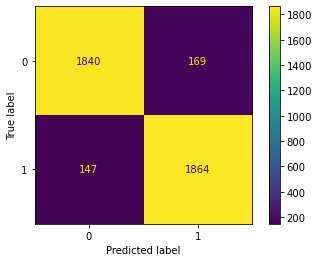

In [115]:
# Logistic Regression with Tfidf on lemmatizing
lr_t_lemma = run_model('tvec', 'lr', X1_train, y1_train, X1_test)

## Score for the random forest

### MODEL METRICS ###


{'model': 'rf',
 'vectorizer': 'tvec',
 'train': 0.9948992286638467,
 'test': 0.9099502487562189,
 '% diff': 0.08494897990762784,
 'computational time (s)': 56.09320640563965,
 'roc': 0.9099450285747949,
 'f_score': 0.9109251968503937,
 'accuracy': 0.9099502487562189}

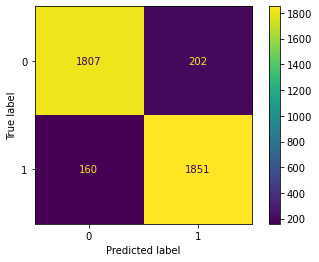

In [116]:
# Random Forest model with Tfdif Vectorizer on lemmatizing
rf_t_lemma = run_model('tvec', 'rf', X2_train, y2_train, X2_test)

### MODEL METRICS ###


{'model': 'rf',
 'vectorizer': 'cvec',
 'train': 0.9952724558347847,
 'test': 0.9069651741293532,
 '% diff': 0.08830728170543156,
 'computational time (s)': 63.302701473236084,
 'roc': 0.9069606957651285,
 'f_score': 0.9078363725973385,
 'accuracy': 0.9069651741293532}

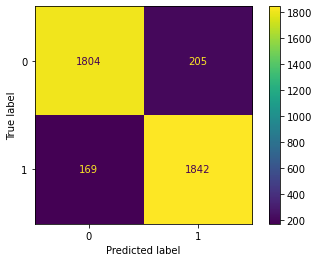

In [117]:
# Random Forest model with CountVectorizer on lemmatizing
rf_c_lemma = run_model('cvec', 'rf', X1_train, y1_train, X1_test)

## Score for multi-nominal Naive Bayes

### MODEL METRICS ###


{'model': 'nb',
 'vectorizer': 'tvec',
 'train': 0.9527245583478477,
 'test': 0.9154228855721394,
 '% diff': 0.037301672775708394,
 'computational time (s)': 4.016489744186401,
 'roc': 0.9154129638902413,
 'f_score': 0.9171136031204291,
 'accuracy': 0.9154228855721394}

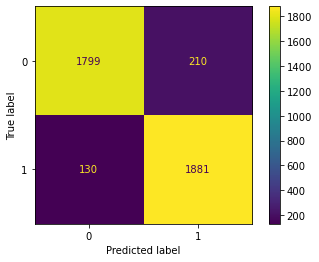

In [118]:
# Naive Bayes with TfdifVectorizer on lemmatizing
nb_t_lemma = run_model('tvec', 'nb', X1_train, y1_train, X1_test)

### MODEL METRICS ###


{'model': 'nb',
 'vectorizer': 'cvec',
 'train': 0.9464419009703906,
 'test': 0.9203980099502488,
 '% diff': 0.02604389102014182,
 'computational time (s)': 3.7279438972473145,
 'roc': 0.9203905646866574,
 'f_score': 0.9216070553650171,
 'accuracy': 0.9203980099502488}

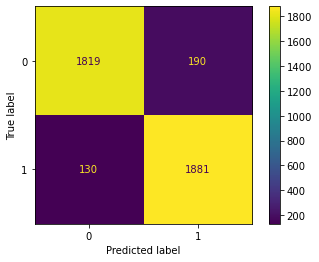

In [119]:
# Naive Bayes with CountVectorizer on lemmatizing
nb_c_lemma = run_model('cvec', 'nb', X1_train, y1_train, X1_test)

## Score for the k-nearest neighbour

### MODEL METRICS ###


{'model': 'knn',
 'vectorizer': 'tvec',
 'train': 0.7886912167205773,
 'test': 0.6320895522388059,
 '% diff': 0.15660166448177137,
 'computational time (s)': 43.037392139434814,
 'roc': 0.632068793363727,
 'f_score': 0.6469324421102889,
 'accuracy': 0.6320895522388059}

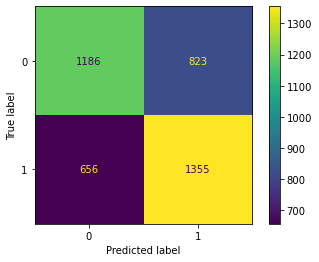

In [120]:
# KNN model with Tfdif Vectorizer on lemmatizing
nb_t_lemma = run_model('tvec', 'knn', X1_train, y1_train, X1_test)

### MODEL METRICS ###


{'model': 'knn',
 'vectorizer': 'cvec',
 'train': 0.8910798706145807,
 'test': 0.8343283582089552,
 '% diff': 0.05675151240562548,
 'computational time (s)': 48.16196131706238,
 'roc': 0.8343109908940349,
 'f_score': 0.8399807784718885,
 'accuracy': 0.8343283582089552}

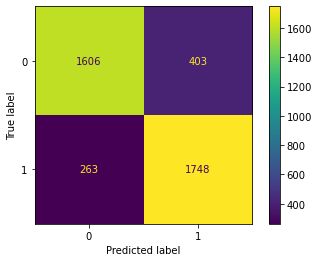

In [121]:
# KNN model with CountVectorizer on lemmatizing
nb_t_lemma = run_model('cvec', 'knn', X1_train, y1_train, X1_test)

In [122]:
model_df = pd.DataFrame(mod_results)
model_df.sort_values(by='accuracy',ascending= False).reset_index(drop=True).head(10)

,model,vectorizer,train,test,% diff,computational time (s),roc,f_score,accuracy
0,lr,tvec,0.966969,0.921393,0.045576,4.419920,0.921390,0.921860,0.921393
1,nb,cvec,0.946442,0.920398,0.026044,3.727944,0.920391,0.921607,0.920398
2,nb,tvec,0.952725,0.915423,0.037302,4.016490,0.915413,0.917114,0.915423
3,lr,cvec,0.980530,0.914677,0.065853,4.381173,0.914671,0.915704,0.914677
4,rf,tvec,0.994899,0.909950,0.084949,56.093206,0.909945,0.910925,0.909950
5,rf,cvec,0.995272,0.906965,0.088307,63.302701,0.906961,0.907836,0.906965
6,knn,cvec,0.891080,0.834328,0.056752,48.161961,0.834311,0.839981,0.834328
7,knn,tvec,0.788691,0.632090,0.156602,43.037392,0.632069,0.646932,0.632090


From the above vectorization method, the Tfidf Vectorizer has a higher score **(f-score=0.921)** than countvectorizer **(f_score=0.9146)** on the logistic regression. Hence, the Tfidf method is selected. 
The top 2 models selected is between the logistic regression and the multinomial Naive Bayes. 

**Assumptions for Multinomial Naive Bayes**
1. Assumption of independence between words (class conditional independance)
2. Determining feature importance requires the use of predicted probabilities

**Assumptions for Logistic Regression**
1. Response is binary 
2. No extreme outliers

From the above assumptions, logistic regression is prefered due to the above assumptions and the high interpretability of the model. Thus, the tvec is the selected vectorizer as it produces the highest result for logistic regression and the tvec vectorizer is selected for the gridsearch.

# Hyper-parameter Tuning 

### Best parameters for the logistic regression, naive bayes, random forest and k-nearest neighbours

In [18]:
# Instantiate tuning list
ht = []

In [13]:
# Instantiate tfidf vectorizer parameters for grid search
tvec_params = {
    'tvec__max_features': [None],
    'tvec__min_df':[3, 4, 5],
    'tvec__max_df': [0.2, 0.3, 0.4],
    #'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [14]:
lr_params = {
    'lr__solver':['newton-cg', 'lbfgs'],
    'lr__C':[0.1, 1, 10]
}

nb_params = {
    'nb__fit_prior': [True, False],
    'nb__alpha': [1, 2]
}

knn_params = {
    'knn__leaf_size':list(range(1,5)),
    'knn__n_neighbors':list(range(1,20)), 
    'knn__p':[1, 2]
}

rf_params = {
    'rf__n_estimators': [150, 300],
    'rf__max_depth': [None, 1]
}

Fitting 5 folds for each of 108 candidates, totalling 540 fits
### BEST PARAMS ###


{'lr__C': 10,
 'lr__solver': 'newton-cg',
 'tvec__max_df': 0.2,
 'tvec__max_features': None,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 2)}

### MODEL METRICS ###


{'model': 'lr',
 'vectorizer': 'tvec',
 'train': 0.9840756407066434,
 'test': 0.9171641791044776,
 '% diff': 0.06691146160216588,
 'computational time (s)': 235.36702609062195,
 'roc': 0.9171635398043464,
 'f_score': 0.917308169853489,
 'accuracy': 0.9171641791044776}

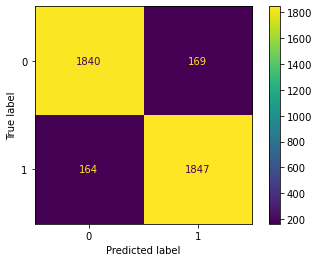

In [19]:
tvec_lr_gs = run_model('tvec', 'lr', X1_train, y1_train, X1_test,
                       vec_params=tvec_params, mod_params=lr_params, grid_search=True)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
### BEST PARAMS ###


{'rf__max_depth': None,
 'rf__n_estimators': 300,
 'tvec__max_df': 0.2,
 'tvec__max_features': None,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 2)}

### MODEL METRICS ###


{'model': 'rf',
 'vectorizer': 'tvec',
 'train': 0.9924110475242598,
 'test': 0.9124378109452737,
 '% diff': 0.07997323657898614,
 'computational time (s)': 1310.5624623298645,
 'roc': 0.9124410070149273,
 'f_score': 0.911911911911912,
 'accuracy': 0.9124378109452737}

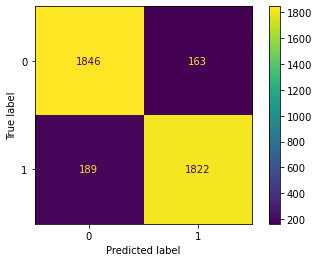

In [23]:
tvec_rf_gs = run_model('tvec', 'rf', X1_train, y1_train, X1_test,
                       vec_params=tvec_params, mod_params=rf_params, grid_search=True)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
### BEST PARAMS ###


{'nb__alpha': 1,
 'nb__fit_prior': False,
 'tvec__max_df': 0.2,
 'tvec__max_features': None,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 2)}

### MODEL METRICS ###


{'model': 'nb',
 'vectorizer': 'tvec',
 'train': 0.9541552625031102,
 'test': 0.9206467661691542,
 '% diff': 0.03350849633395603,
 'computational time (s)': 140.76673698425293,
 'roc': 0.9206391972077911,
 'f_score': 0.9218711731569924,
 'accuracy': 0.9206467661691542}

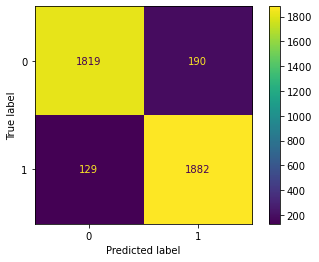

In [28]:
tvec_nb_gs = run_model('tvec', 'nb', X1_train, y1_train, X1_test,
                       vec_params=tvec_params, mod_params=nb_params, grid_search=True)

In [ ]:
#tvec_knn_gs = run_model('tvec', 'knn', X1_train, y1_train, X1_test,
                       #vec_params=tvec_params, mod_params=knn_params, grid_search=True)

Due to the high number of fits (13680) from the knn model (candidates = 2736) and the low f-score (0.67) of knn model. A grid search is not conducted on the knn model as it would not likely to have a better score compared to the other models (logistic regression, random forest and naive bayes) evaluated.

In [27]:
model_tuning_df = pd.DataFrame(ht)
model_tuning_df.sort_values(by=['f_score', 'roc'], ascending=False).reset_index(drop=True)

,model,vectorizer,train,test,% diff,computational time (s),roc,f_score,accuracy
1,nb,tvec,0.954155,0.920647,0.033508,171.847480,0.920639,0.921871,0.920647
2,lr,tvec,0.984076,0.917164,0.066911,261.895219,0.917164,0.917308,0.917164
3,rf,tvec,0.992411,0.912438,0.079973,1310.562462,0.912441,0.911912,0.912438


From the above table, all three models are not considered overfitted as the % difference between train and test is less than 5%. 
Both naive bayes and logistic regression has a similar computational times, f-score, accuracy, and roc.

Despite the slightly higher score for the naive bayes, the logistic regression is selected as the production model due to the interpretebility of the output.

# Final Model Selection & Insights on Final Model

In [21]:
#Instantiate empty list
top_coef = []

In [2]:
def top_coef_model(best_param_model):
    coefs = pd.DataFrame(best_param_model.best_estimator_.steps[1][1].coef_).T
    coefs.columns = ['coef']
    coefs['feature'] = best_param_model.best_estimator_.steps[0][1].get_feature_names()
    coefs = coefs[['feature','coef']]
    coefs = coefs.sort_values('coef', ascending=True)

    top_dc_coefs = coefs.head(15).reset_index(drop=True)
    top_marvel_coefs = coefs.tail(15).sort_values(by='coef', ascending=False).reset_index(drop=True)

    fig, axs = plt.subplots(1, 2, figsize=(20,7))
    axs[0].title.set_text('Top 15 Features Correlated with DC')
    axs[1].title.set_text('Top 15 Feature Correlated Marvel')
    # axs[0].yaxis.tick_right()
    sns.barplot(data = top_dc_coefs, x = 'coef',y='feature',ax = axs[0])
    sns.barplot(data = top_marvel_coefs, x = 'coef',y='feature',ax = axs[1])
    plt.show();

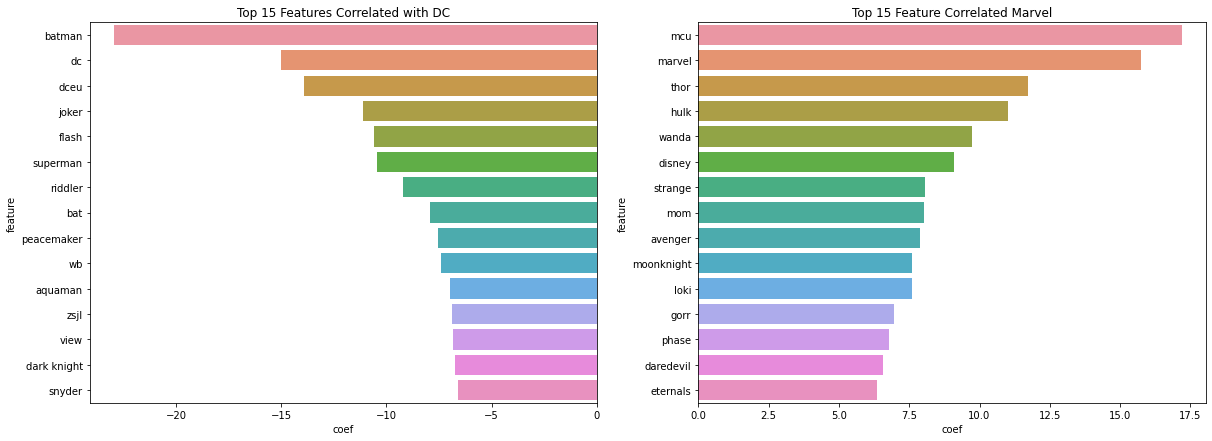

In [27]:
top_coef_model(tvec_lr_gs)

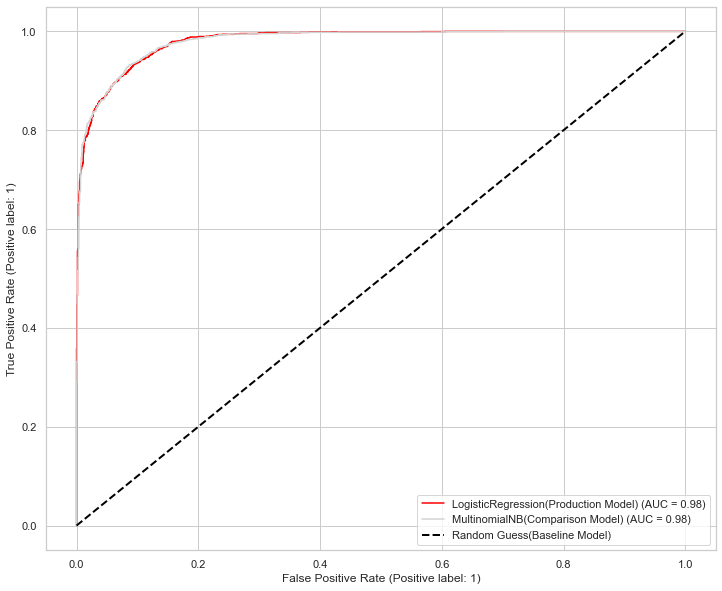

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
plot_roc_curve(tvec_lr_gs, X_test, y_test, ax=ax, name='LogisticRegression(Production Model)', color='red')
plot_roc_curve(tvec_nb_gs, X_test, y_test, ax=ax, name='MultinomialNB(Comparison Model)', color='lightgrey')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess(Baseline Model)')
plt.legend()

In this section, both the top feature columns from the logistic regression is plotted above and the impact. This top features also indicates that there these are the top characters from both marvel and dc_cinnematics subreddits allowing more insights from the market data.

Since accuracy equates to the ROC, a plot of the 3 model is shown above. From this plot, there is negligible differences between the top two models. 

# Sentiment Analysis

Prior to fitting the market data, a label sentiment dataset was created by labelling 150 posts from r/marvelstudios and r/DC_Cinnematic accordingly (NEU=neutral, POS=positive, NEG=negative). This labeled dataset is tested on the two classifier models and evaluated using the accuracy of the model.

In [33]:
# Comparing both classifier models

sent_classifier0 = pipeline("sentiment-analysis", 
                            model="cardiffnlp/twitter-roberta-base-sentiment",  
                            max_length=512, 
                            truncation=True)

sent_classifier = pipeline("sentiment-analysis", 
                          model="finiteautomata/bertweet-base-sentiment-analysis", 
                          truncation=True)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [36]:
# Load the human labelled dataset 
sentiment_test = pd.read_csv('./datasets/manual_sentiment_annotated_data - manual_sentiment_annotated_data.csv')

In [136]:
# Run both sentiment analysis models on the posts 
sentiment_test['model_output1'] = sentiment_test['post_demojized_only'].progress_apply(sent_classifier0)
sentiment_test['model_output2'] = sentiment_test['post_demojized_only'].progress_apply(sent_classifier)

# Put both models' predictions into a new column
sentiment_test['model1_label']=[lst[0]['label'] for lst in sentiment_test['model_output1']]
sentiment_test['model1_label']=sentiment_test['model1_label'].map({'LABEL_0':'NEG', 'LABEL_1':'NEU', 'LABEL_2':'POS'})
sentiment_test['model2_label']=[lst[0]['label'] for lst in sentiment_test['model_output2']]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [38]:
# Calculate each model's accuracy
correct_pred_cnt0 = sum(sentiment_test['manual_sentiment']==sentiment_test['model1_label'])
print(f"model_1 accuracy: {correct_pred_cnt0/sentiment_test['manual_sentiment'].count()}")

correct_pred_cnt = sum(sentiment_test['manual_sentiment']==sentiment_test['model2_label'])
print(f"model_2 accuracy: {correct_pred_cnt/sentiment_test['manual_sentiment'].count()}")

model0 accuracy: 0.7566666666666667
model accuracy: 0.7333333333333333


Due to the higher score of the first model_1 **("cardiffnlp/twitter-roberta-base-sentiment")**, this model is selected for the data for the sentiment analysis and it is fitted to the non-tokenized data.

## Sentiment analysis on data and EDA on output

In [35]:
tqdm_notebook.pandas()
model_name = "finiteautomata/bertweet-base-sentiment-analysis"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

classifier = pipeline("sentiment-analysis",
                      model= model, tokenizer=tokenizer,
                     truncation=True)
df['sentiment_analysis_output'] = df['post'].progress_apply(classifier)

  0%|          | 0/20096 [00:00<?, ?it/s]

In [81]:
df_c = df.copy()
df_c['output'] = df_c['sentiment_analysis_output'].apply(pd.Series)
df_c['output'].apply(pd.Series)
output_df = pd.concat([df_c, df_c['output'].apply(pd.Series)], axis=1)
sa_df = output_df.drop(columns=['sentiment_analysis_output', 'output'])
sa_df.head()

,is_marvelstudios,post,post_clean_lemma,post_clean_stem,label,score
0,1,Unpopular Opinion: Who cares that the MCU is l...,unpopular opinion care mcu labeled really not ...,unpopular opinion care mcu label realli not bi...,NEG,0.936026
1,1,What's your favorite MCU Content Youtube Chann...,favorite mcu content youtube channel breakdown...,favorit mcu content youtub channel breakdown e...,NEU,0.744970
2,1,I'd rather rewatch Thor 1 than Thor Ragnarok S...,rather rewatch thor thor ragnarok month ago wa...,rather rewatch thor thor ragnarok month ago wa...,NEG,0.959809
3,1,"Venom is a Mimic Like, they both have the same...",venom mimic design alien kind disguise turn pe...,venom mimic design alien kind disguis turn peo...,NEU,0.557894
4,1,Who do you guys think would win gwenpool or mi...,guy win gwenpool mile morale battling mcu endg...,guy win gwenpool mile moral battl mcu endgam f...,NEU,0.962745


## EDA on output data

In [3]:
# Export output for sentiment analysis to csv (Saving Output) to comment out after saving
#sa_df.to_csv('./datasets/sentiment_analysis.csv')

# Import output for sentiment analysis to csv (Load Save Output)
sa_df = pd.read_csv('./datasets/sentiment_analysis.csv')

In [47]:
sentiment = sa_df.groupby(by='label')['is_marvelstudios'].value_counts()
sentiment

label  is_marvelstudios
NEG    1                   1583
       0                   1484
NEU    1                   6552
       0                   6320
POS    0                   2241
       1                   1916
Name: is_marvelstudios, dtype: int64

<AxesSubplot:title={'center':'r/DC_Cinnematic sentiment analysis'}>

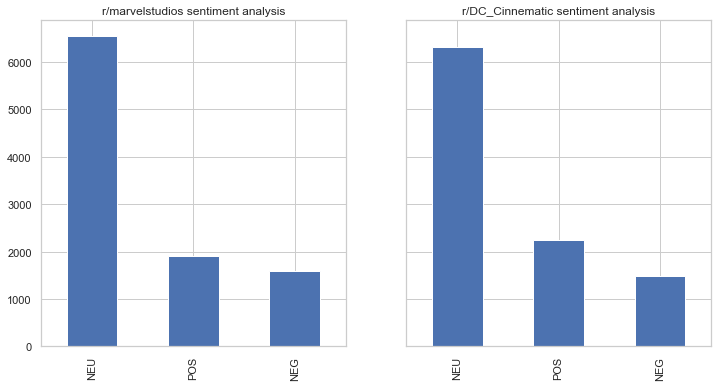

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
ax = ax.ravel()
sns.set_theme(style="whitegrid")
msst = sa_df[sa_df['is_marvelstudios']==1]['label'].value_counts()
msst.plot(kind='bar', title='r/marvelstudios sentiment analysis', ax=ax[0])
dcst = sa_df[sa_df['is_marvelstudios']==0]['label'].value_counts()
dcst.plot(kind='bar', title='r/DC_Cinnematic sentiment analysis', ax=ax[1])

A significant amount of the neutral comments is found in both dc_cinnematic and marvelstudio threads. This is congruent with the post as a significant number of post are discussion on plots in series.

In [127]:
positive = sa_df[sa_df['label']=='POS']
positive.reset_index()
positive.drop(columns='Unnamed: 0')

,is_marvelstudios,post,post_clean_lemma,post_clean_stem,label,score
6,1,"I don't know about all of you, but I think Ant...",antony starr make fine johnny storm antony sta...,antoni starr make fine johnni storm antoni sta...,POS,0.956300
12,1,Hopefully we get these outfits for MCU X-Men H...,hopefully get outfit mcu x men hopefully get o...,hope get outfit mcu x men hope get outfit mcu ...,POS,0.916752
17,1,Do you think gwenpool could make an appearance...,gwenpool make appearance mcu cool she since sh...,gwenpool make appear mcu cool she sinc she kin...,POS,0.826691
21,1,I've only seen Spiderman. Ask me anything abou...,seen spiderman ask anything marvel seen spider...,seen spiderman ask anyth marvel seen spiderman...,POS,0.915689
22,1,I've only seen Spiderman. Ask me anything abou...,seen spiderman ask anything marvel seen spider...,seen spiderman ask anyth marvel seen spiderman...,POS,0.915689
...,...,...,...,...,...,...
20080,0,Idk why i laughed so hard at this Idk why i la...,idk laughed hard idk laughed hard,idk laugh hard idk laugh hard,POS,0.920317
20084,0,"FAN-MADE: And the league looked up and said, ""...",fan made league looked said wow fan made leagu...,fan made leagu look said wow fan made leagu lo...,POS,0.618859
20085,0,DISCUSSION: The Future of DCEU 2022 and BEYOND...,discussion future dceu beyond hi amp x b gener...,discuss futur dceu beyond hi amp x b gener pos...,POS,0.932463
20092,0,Is the Watchmen show worth watching? I finishe...,watchman worth watching finished not long ago ...,watchmen worth watch finish not long ago love ...,POS,0.814507


In [15]:
# Determining the stopwords list
stop_words = stopwords.words('english')
extra_words = ['like', 'would', 'think', 'removed', 'movie', 'see', 'one' 'film', 
               'know', 'one', 'could', 'love', 'new', 'film', 'show', 'poll', 'https'
               ,'www', 'reddit', 'com', 'live', 'action', 'scene']
#excl_words = ['she', 'not']
stop_words.extend(extra_words)
stop_words.remove('she')
stop_words.remove('not')

In [27]:
# Creating plots for the tokenizing for the eda
def plot_top_tokens(df0, df1, col, n, n_gram_range, title0, title1, palette='tab10'):
    def get_top_n_tokens(corpus, n=n, k=n_gram_range):     
        vec = CountVectorizer(ngram_range=(k,k), stop_words = stop_words).fit(corpus)     
        bag_of_words = vec.transform(corpus)     
        sum_words = bag_of_words.sum(axis=0)      
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]    
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) 
        return words_freq[:n]
    
    temp_df0 = pd.DataFrame(data=get_top_n_tokens(df0[col], n), columns=['word','freq'])
    temp_df1 = pd.DataFrame(data=get_top_n_tokens(df1[col], n), columns=['word','freq'])
    #plt.figure(figsize=(10,6))
    fig, axs = plt.subplots(1, 2, figsize=(20,7))
    axs[0].title.set_text(title0)
    axs[1].title.set_text(title1)
    # axs[0].yaxis.tick_right()
    #sns.barplot(data = get_top_n_tokens(df0[col], n), columns=['word','freq'],ax = axs[0])
    #sns.barplot(data = get_top_n_tokens(df1[col], n), columns=['word','freq'],ax = axs[1])
    
    sns.barplot(data=temp_df0, y='word', x='freq', palette=palette, ax= axs[0])
    sns.barplot(data=temp_df1, y='word', x='freq', palette=palette, ax= axs[1])
    plt.ylabel('')
    plt.xlabel('')
    #plt.title(title, fontsize=18)

In [14]:
pos_ma = sa_df[(sa_df['label']=='POS')&(sa_df['is_marvelstudios']==1)]
pos_dc = sa_df[(sa_df['label']=='POS')&(sa_df['is_marvelstudios']==0)]
neg_ma = sa_df[(sa_df['label']=='NEG')&(sa_df['is_marvelstudios']==1)]
neg_dc = sa_df[(sa_df['label']=='NEG')&(sa_df['is_marvelstudios']==0)]
neg_dc

,Unnamed: 0,is_marvelstudios,post,post_clean_lemma,post_clean_stem,label,score
10053,10095,0,So turns out Ezra grooming or kidnapping alleg...,turn ezra grooming kidnapping allegation false...,turn ezra groom kidnap alleg fals turn ezra gr...,NEG,0.962512
10058,10100,0,so about Batman being a killer... I don't disl...,batman killer dislike not comic accurate reaso...,batman killer dislik not comic accur reason du...,NEG,0.972048
10061,10103,0,I hated this movie I hated this movie,hated hated,hate hate,NEG,0.983724
10064,10106,0,"Is it really surprising, that the most controv...",really surprising controversial figure dc figu...,realli surpris controversi figur dc figur cont...,NEG,0.932002
10065,10107,0,Damn you Barry Damn you Barry,damn barry damn barry,damn barri damn barri,NEG,0.961461
...,...,...,...,...,...,...,...
20059,20153,0,How do you handle Batman in the DCEU? Keaton k...,handle batman dceu keaton kinda kill chance st...,handl batman dceu keaton kinda kill chanc stan...,NEG,0.884034
20062,20156,0,"“Never start with the head, the victim gets al...",never start head victim get fuzzy camera flash...,never start head victim get fuzzi camera flash...,NEG,0.792013
20064,20158,0,I fucking hate the Snyder Cult [removed],fucking hate snyder cult,fuck hate snyder cult,NEG,0.984316
20070,20164,0,The Dark Knight: What do you think of the batm...,dark knight batman nolan trilogy friend tell a...,dark knight batman nolan trilog friend tell al...,NEG,0.492274


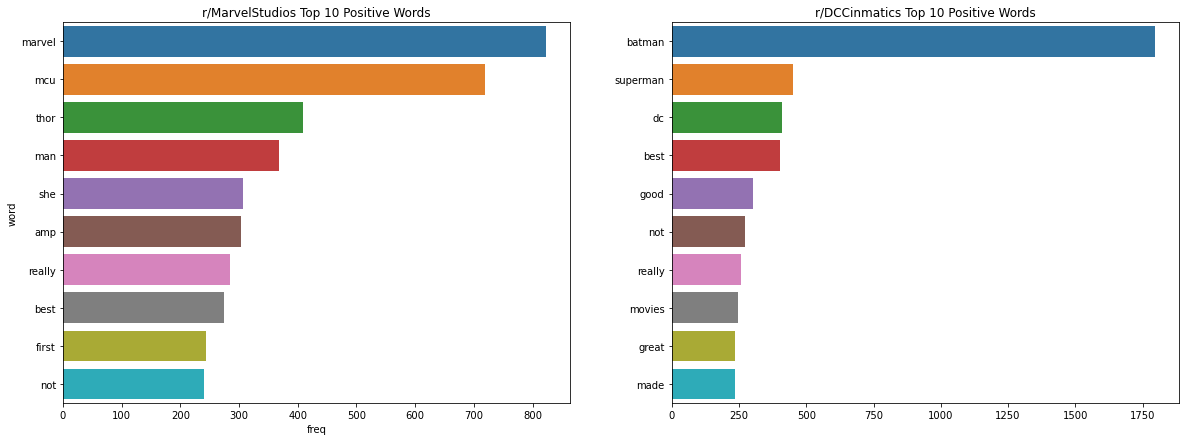

In [30]:
plot_top_tokens(pos_ma, pos_dc, 'post', 10, 1, 'r/MarvelStudios Top 10 Positive Words', 'r/DCCinmatics Top 10 Positive Words')

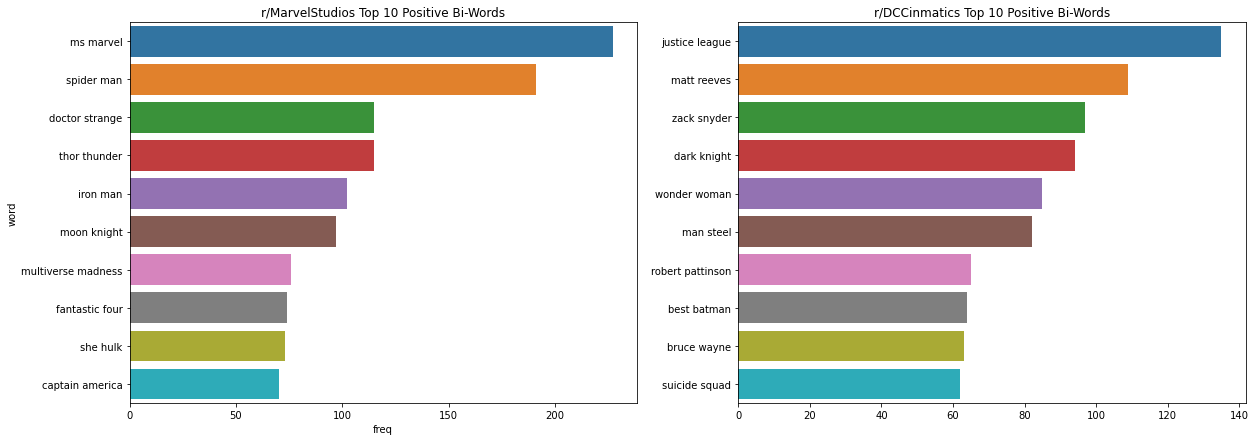

In [31]:
plot_top_tokens(pos_ma, pos_dc, 'post', 10, 2, 'r/MarvelStudios Top 10 Positive Bi-Words', 'r/DCCinmatics Top 10 Positive Bi-Words')

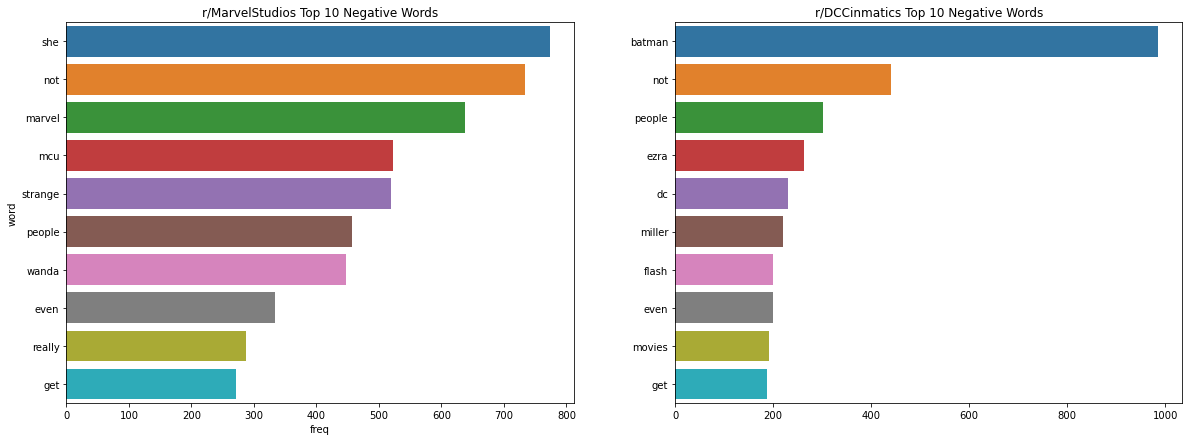

In [35]:
plot_top_tokens(neg_ma, neg_dc, 'post', 10, 1, 'r/MarvelStudios Top 10 Negative Words', 'r/DCCinmatics Top 10 Negative Words')

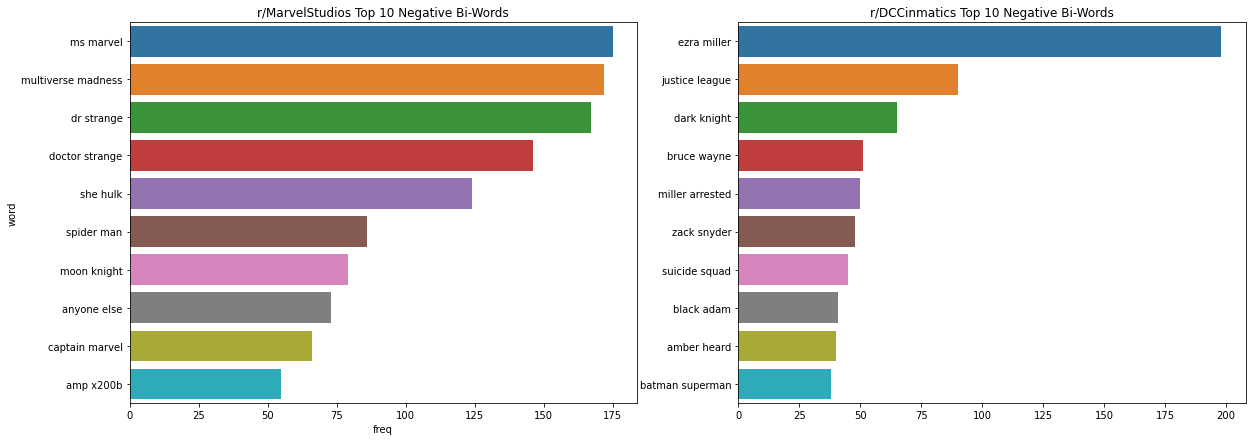

In [34]:
plot_top_tokens(neg_ma, neg_dc, 'post', 10, 2, 'r/MarvelStudios Top 10 Negative Bi-Words', 'r/DCCinmatics Top 10 Negative Bi-Words')

## Conclusion and Recommendations

In conclusion the production model is able to successfully classify Reddit posts as Marvel/DC content and possible future applications includes:
1. Classify text data from other non-Reddit sources 
2. Can be used to to determine popularity/public interest in each brand 
3. Other downstream analysis e.g. sentiment analysis 

Key findings from sentiment analysis: 
1. Characters to develop toys and marketing initiatives for  
2. Key characters to avoid